# H-1B Visa Petition
## 04:Classical Model Benchmarking
**Author:** Prasoon Karmacharya

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import (accuracy_score, confusion_matrix, plot_confusion_matrix,
                             ConfusionMatrixDisplay, classification_report, 
                             f1_score, recall_score, precision_score, 
                             roc_curve, roc_auc_score, hamming_loss, jaccard_score)

RANDOM_STATE = 42


from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler

In [2]:

def evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, y_pred_val, y_pred_test, classifier, clf):
    print("-----------------------------------------------")
    print("Clf: ", classifier.__class__.__name__)
    model_results = {}
    
    model_results['Classifier'] = classifier.__class__.__name__
    
    model_results['Accuracy (train)'] = clf.score(X_train, y_train)
    
    # Validation Performance
    model_results['Accuracy (val)'] = clf.score(X_val, y_val)
    model_results['Accuracy (test)'] = clf.score(X_test, y_test)
    
    model_results['Recall (val)'] = recall_score(y_val, y_pred_val, average='weighted', labels=np.unique(y_pred_val))
    model_results['Precision (val)'] = precision_score(y_val, y_pred_val, average='weighted', labels=np.unique(y_pred_val))
    model_results['F1-score (val)'] = f1_score(y_val, y_pred_val, average='weighted', labels=np.unique(y_pred_val))
    model_results['AUC-ROC (val)'] = roc_auc_score(y_val, y_pred_val)
    model_results['Jacard score (val)'] = jaccard_score(y_val, y_pred_val,average='weighted', labels=np.unique(y_pred_test))
    model_results['Hamming Loss (val)'] = hamming_loss(y_val, y_pred_val)
    
    model_results['CV Accuracy'] = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    # Test Performance
    model_results['Recall (test)'] = recall_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    model_results['Precision (test)'] = precision_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    model_results['F1-score (test)'] = f1_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    model_results['AUC-ROC (test)'] = roc_auc_score(y_test, y_pred_test)
    model_results['Jacard score (test)'] = jaccard_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    model_results['Hamming Loss (test)'] = hamming_loss(y_test, y_pred_test)

    return model_results


def run_model(classifier, X_train, y_train, X_val, y_val, X_test, y_test):
    model = classifier
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    return model, y_pred_val, y_pred_test

In [3]:
# Read Data

In [4]:
data = pd.read_pickle("../assets/data/cleaned_h1b.pkl")

In [5]:
data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,YEAR_coded,SOC_NAME_coded
0,1,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,0,36067.0,2016.0,"ANN ARBOR, MICHIGAN",5,192
1,1,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,1,242674.0,2016.0,"PLANO, TEXAS",5,297
2,1,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,1,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",5,297
3,1,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",1,220314.0,2016.0,"DENVER, COLORADO",5,297
5,1,BURGER KING CORPORATION,CHIEF EXECUTIVES,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",1,225000.0,2016.0,"MIAMI, FLORIDA",5,297


In [6]:
feature_cols = ['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR_coded', 'SOC_NAME_coded']
target_col = ['CASE_STATUS']

* Split the data into dev, validation, and test set 60:10:10

In [7]:
# dev, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
dev, test = train_test_split(data, test_size=0.15, random_state=RANDOM_STATE)

In [8]:
train, val = train_test_split(dev, test_size=0.15, random_state=RANDOM_STATE)

In [9]:
train.shape[0]/data.shape[0]

0.7224995916862134

In [10]:
val.shape[0]/data.shape[0]

0.1275002529301046

In [11]:
test.shape[0]/data.shape[0]

0.15000015538368203

In [12]:
X_train = train[feature_cols]
y_train = train[target_col]

X_val = val[feature_cols]
y_val = val[target_col]

X_test = test[feature_cols]
y_test = test[target_col]

In [13]:
y_train["CASE_STATUS"].value_counts(normalize=True)

1    0.967274
0    0.032726
Name: CASE_STATUS, dtype: float64

In [14]:
y_train["CASE_STATUS"].value_counts()

1    2023925
0      68475
Name: CASE_STATUS, dtype: int64

In [15]:
68475*(.75/.25)

205425.0

In [16]:
sampling_strategy = {0:68475, 1:205425}
X_train_balanced, y_train_balanced = make_imbalance(X_train, 
                                                    y_train, 
                                                    sampling_strategy=sampling_strategy, 
                                                    random_state=RANDOM_STATE)

In [17]:
y_train_balanced["CASE_STATUS"].value_counts(normalize=True)

1    0.75
0    0.25
Name: CASE_STATUS, dtype: float64

In [18]:
def run_it(X_train, y_train, X_val, y_val, X_test, y_test): 
    model_benchmark = pd.DataFrame(columns=['Classifier', 'Accuracy (train)', 'Accuracy (val)', 'Accuracy (test)', 'CV Accuracy', 
                                            'Recall (val)', 'Precision (val)', 'F1-score (val)', 'AUC-ROC (val)', 'Jacard score (val)', 'Hamming Loss (val)',
                                            'Recall (test)', 'Precision (test)', 'F1-score (test)', 'AUC-ROC (test)', 'Jacard score (test)', 'Hamming Loss (test)'
                                           ])

    sgd = SGDClassifier()
    lr = LogisticRegression(solver='lbfgs')
    svc = LinearSVC()
    mnb = MultinomialNB()
    dt = DecisionTreeClassifier()
    gb = GradientBoostingClassifier()
    ada = AdaBoostClassifier()
    classifier_list = [sgd, lr, svc, mnb, dt, gb, ada]
    models_object_list = []
    
    for classifier in classifier_list:        
        clf, y_pred_val, y_pred_test = run_model(classifier, X_train, y_train, X_val, y_val, X_test, y_test)
        model_result = evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, y_pred_val, y_pred_test, classifier, clf)
        model_benchmark = model_benchmark.append(model_result, ignore_index=True)
        
        models_object_list.append(clf)

    return model_benchmark, models_object_list 

In [19]:
model_benchmark_df, models_object_list = run_it(X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test)

/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


-----------------------------------------------
Clf:  SGDClassifier


/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

-----------------------------------------------
Clf:  LogisticRegression


/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

-----------------------------------------------
Clf:  LinearSVC


/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/

-----------------------------------------------
Clf:  MultinomialNB


/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

-----------------------------------------------
Clf:  DecisionTreeClassifier


/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


-----------------------------------------------
Clf:  GradientBoostingClassifier


/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

-----------------------------------------------
Clf:  AdaBoostClassifier


/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/karma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

In [20]:
rearranged_metrics = ['Classifier', 'Accuracy (train)', 'Accuracy (val)', 'Accuracy (test)', 'CV Accuracy', 
                      'Recall (val)', 'Recall (test)', 
                      'Precision (val)', 'Precision (test)', 
                      'F1-score (val)',  'F1-score (test)',
                      'AUC-ROC (val)', 'AUC-ROC (test)',
                      'Jacard score (val)', 'Jacard score (test)', 
                      'Hamming Loss (val)', 'Hamming Loss (test)']
model_benchmark_df.sort_values(by="F1-score (test)")[rearranged_metrics]

,Classifier,Accuracy (train),Accuracy (val),Accuracy (test),CV Accuracy,Recall (val),Recall (test),Precision (val),Precision (test),F1-score (val),F1-score (test),AUC-ROC (val),AUC-ROC (test),Jacard score (val),Jacard score (test),Hamming Loss (val),Hamming Loss (test)
0,SGDClassifier,0.426564,0.408243,0.408643,0.687649,0.408243,0.408643,0.929286,0.930122,0.553480,0.553866,0.445105,0.448804,0.386816,0.387168,0.591757,0.591357
4,DecisionTreeClassifier,0.906057,0.846732,0.846115,0.754403,0.846732,0.846115,0.951266,0.951194,0.891380,0.891057,0.662037,0.658966,0.820039,0.819518,0.153268,0.153885
3,MultinomialNB,0.737696,0.918732,0.919320,0.737707,0.918732,0.919320,0.940666,0.941064,0.929329,0.929820,0.531008,0.532633,0.890230,0.890949,0.081268,0.080680
6,AdaBoostClassifier,0.776623,0.921264,0.920568,0.775776,0.921264,0.920568,0.948341,0.948135,0.933768,0.933320,0.612474,0.608424,0.894195,0.893528,0.078736,0.079432
5,GradientBoostingClassifier,0.781997,0.925893,0.925950,0.781559,0.925893,0.925950,0.948915,0.948992,0.936558,0.936632,0.616042,0.614807,0.898923,0.899057,0.074107,0.074050
2,LinearSVC,0.747871,0.957625,0.957892,0.548244,0.957625,0.957892,0.939030,0.939433,0.947906,0.948225,0.506215,0.506897,0.927279,0.927692,0.042375,0.042108
1,LogisticRegression,0.753954,0.968298,0.968396,0.753950,0.968298,0.968396,0.968145,0.968465,0.953274,0.953378,0.508848,0.508269,0.937622,0.937807,0.031702,0.031604


In [21]:
models_object_list

[SGDClassifier(),
 LogisticRegression(),
 LinearSVC(),
 MultinomialNB(),
 DecisionTreeClassifier(),
 GradientBoostingClassifier(),
 AdaBoostClassifier()]

In [22]:
clf_name_list = ["SGD", "Logistic Regression", "Linear SVC", 
                 "Multinomial NB", "Decision Tree", 
                 "Gradient Boosting", "Ada Boost"]

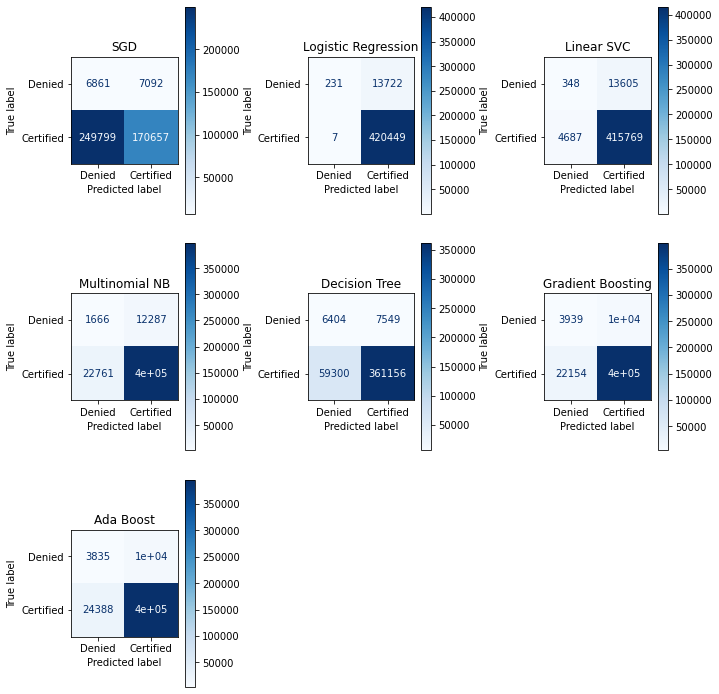

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

for clf, ax, clf_name in zip(models_object_list, axes.flatten(), clf_name_list):
    plot_confusion_matrix(clf, X_test, y_test, ax=ax, cmap='Blues', display_labels=["Denied", "Certified"])
#     ax.title.set_text(type(clf).__name__)
    ax.title.set_text(clf_name)

plt.tight_layout()
plt.show()

/home/karma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


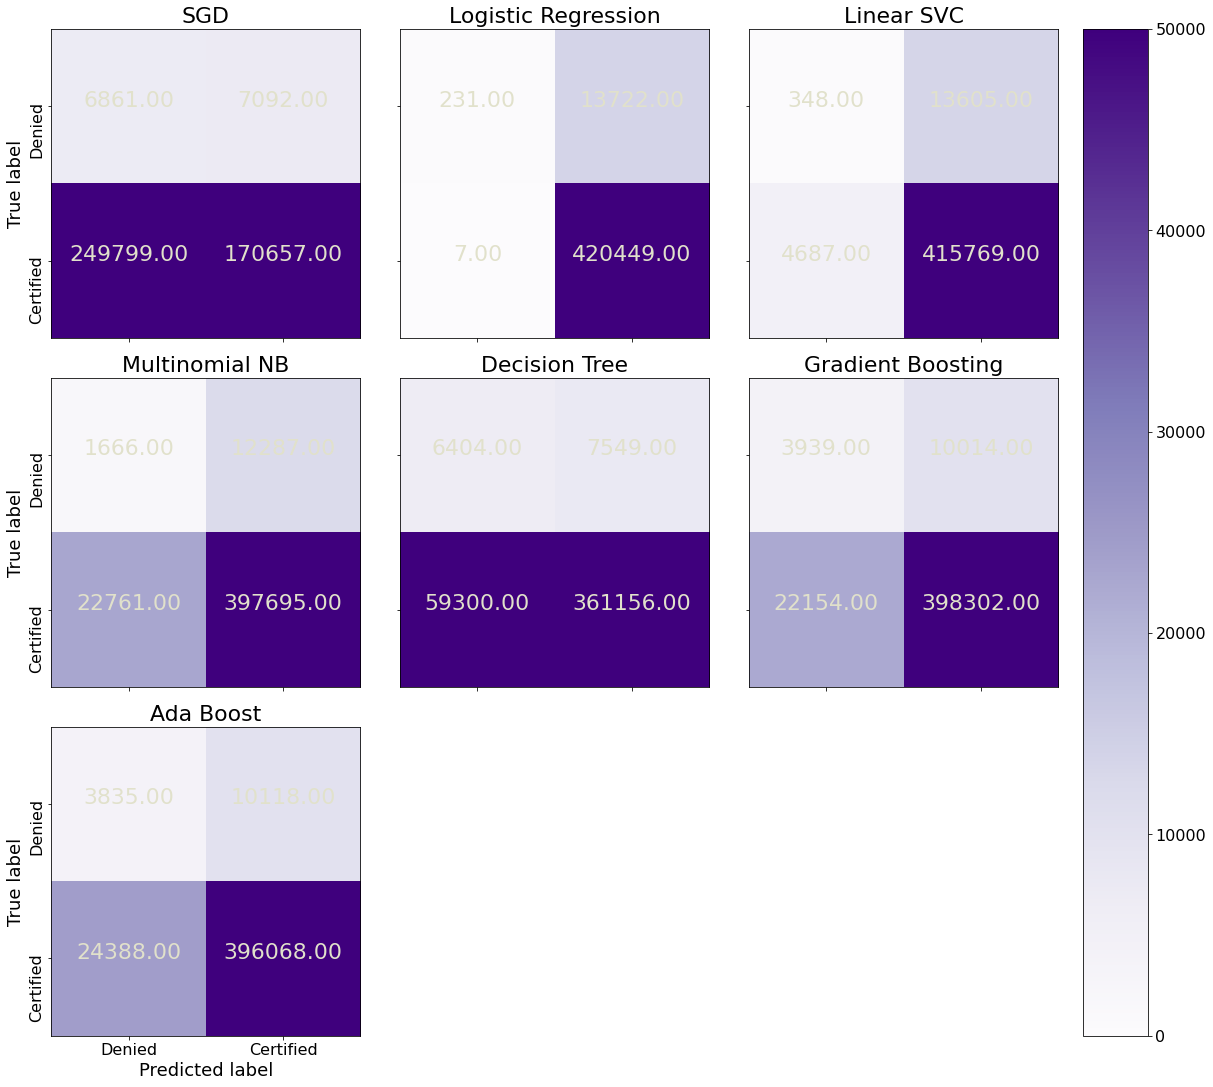

In [26]:
import itertools
from mpl_toolkits.axes_grid1 import ImageGrid


classes = ["Denied", "Certified"]

fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(3,3),
                 axes_pad=0.55,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.35,
                 )

for ax, clf, clf_name in zip(grid[:7], models_object_list, clf_name_list ):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    im = ax.imshow(cm, vmin=0, vmax=50_000, cmap='Purples')
    ax.set_title(clf_name, fontdict = {'fontsize' : 22})
    
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)  # Warning: different signature for [x|y]ticks in pyplot and OO interface
    ax.set_xticklabels(classes, rotation=0, fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, fontsize=16)

    for j, k in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(k, j, format(cm[j, k], '.2f'),
                 horizontalalignment="center",
                 color="#e1e1cb",
                 fontsize=22)

    ax.set_ylabel('True label', fontsize=18)
    ax.set_xlabel('Predicted label', fontsize=18)

fig.delaxes(grid[7])
fig.delaxes(grid[8])

fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.colorbar(im, cax=ax.cax)
ax.cax.tick_params(labelsize=16)

plt.show()

> Since the objective is to maximize the True Positive Rate (Recall) and Minimize the false positive (Precision), F1-score which is the harmonic mean of Recall and Precision is used as the performance evaluation metric. 
* Top three classifiers with highest F1 score are Logistic Regression, Gradient Boost and Ada Boost.
* There is still some room for improvement so next step is to hyper-parameter tune these models and introduce engineered features to the dataset.

In [25]:
(X_train_balanced.shape[0]/data.shape[0]) * 100

9.457686778954972

In [27]:
X_test.shape

(434409, 4)

In [28]:
y_test["CASE_STATUS"].value_counts()

1    420456
0     13953
Name: CASE_STATUS, dtype: int64